### Actividad 2

In [146]:
import pyhive.hive as hive
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.style as style

conn = hive.Connection(host="localhost", port=10000, username="hadoop")

In [77]:
# Eliminar la tabla si ya existe
with conn.cursor() as cursor:
    cursor.execute("DROP TABLE IF EXISTS temp_m")

# Crear la nueva tabla
create_table_query = """
    CREATE TABLE temp_m (
      year_month STRING,
      month_of_release STRING,
      passenger_type STRING,
      direction STRING,
      sex STRING,
      age STRING,
      estimate FLOAT,
      standard_error FLOAT,
      status STRING
    )
    ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    STORED AS TEXTFILE
"""

with conn.cursor() as cursor:
    cursor.execute(create_table_query)
    
# Inserción de datos en la tabla
insert_query = "LOAD DATA INPATH '/lab2/migracio_estimada_por_edad_sexo.csv' INTO TABLE temp_m";
with conn.cursor() as cursor:
    cursor.execute(insert_query)  

# Consulta de datos en Hive
select_query = "select * from temp_m limit 5"
with conn.cursor() as cursor:
    cursor.execute(select_query)
    results = cursor.fetchall()
    for row in results:
        print(row)

('"year_month"', '"month_of_release"', '"passenger_type"', '"direction"', '"sex"', '"age"', None, None, '"status"')
('"2001-01"', '"2020-09"', '"Long-term migrant"', '"Arrivals"', '"Female"', '"0-4 years"', 344.0, 0.0, '"Final"')
('"2001-02"', '"2020-09"', '"Long-term migrant"', '"Arrivals"', '"Female"', '"0-4 years"', 269.0, 0.0, '"Final"')
('"2001-03"', '"2020-09"', '"Long-term migrant"', '"Arrivals"', '"Female"', '"0-4 years"', 239.0, 0.0, '"Final"')
('"2001-04"', '"2020-09"', '"Long-term migrant"', '"Arrivals"', '"Female"', '"0-4 years"', 233.0, 0.0, '"Final"')


In [78]:
# Eliminar la tabla si ya existe
with conn.cursor() as cursor:
    cursor.execute("DROP TABLE IF EXISTS migracion_edad_g")
    
# Crear la nueva tabla
with conn.cursor() as cursor:
    cursor.execute("""
        CREATE TABLE migracion_edad_g (
          year_month STRING,
          month_of_release STRING,
          passenger_type STRING,
          direction STRING,
          sex STRING,
          age STRING,
          estimate FLOAT,
          standard_error FLOAT,
          status STRING
        )
        STORED AS ORC
    """)
cursor.execute("ALTER TABLE migracion_edad_g SET TBLPROPERTIES ('transactional'='true')")    

In [79]:
cursor.execute("""
    INSERT INTO TABLE migracion_edad_g
    SELECT * FROM temp_m
""")

In [80]:
select_query = "SELECT * FROM migracion_edad_g limit 5"
with conn.cursor() as cursor:
 cursor.execute(select_query)
 results = cursor.fetchall()
 for row in results:
     print(row)

('"year_month"', '"month_of_release"', '"passenger_type"', '"direction"', '"sex"', '"age"', None, None, '"status"')
('"2001-01"', '"2020-09"', '"Long-term migrant"', '"Arrivals"', '"Female"', '"0-4 years"', 344.0, 0.0, '"Final"')
('"2001-02"', '"2020-09"', '"Long-term migrant"', '"Arrivals"', '"Female"', '"0-4 years"', 269.0, 0.0, '"Final"')
('"2001-03"', '"2020-09"', '"Long-term migrant"', '"Arrivals"', '"Female"', '"0-4 years"', 239.0, 0.0, '"Final"')
('"2001-04"', '"2020-09"', '"Long-term migrant"', '"Arrivals"', '"Female"', '"0-4 years"', 233.0, 0.0, '"Final"')


In [94]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from pyhive import hive

# Parámetros de conexión a Hive
host = '127.0.0.1'
port = 10000
database = 'default'

# Crear la conexión SQLAlchemy con PyHive
engine = create_engine(f'hive://{host}:{port}/{database}')

# Ejecutar una consulta y obtener los resultados en un DataFrame de Pandas
query = 'SELECT * FROM migracion_edad_g'
df = pd.read_sql(query, engine)

# Mostrar los resultados
print(df)

         year_month    month_of_release       passenger_type    direction  \
0      "year_month"  "month_of_release"     "passenger_type"  "direction"   
1         "2001-01"           "2020-09"  "Long-term migrant"   "Arrivals"   
2         "2001-02"           "2020-09"  "Long-term migrant"   "Arrivals"   
3         "2001-03"           "2020-09"  "Long-term migrant"   "Arrivals"   
4         "2001-04"           "2020-09"  "Long-term migrant"   "Arrivals"   
...             ...                 ...                  ...          ...   
47519     "2022-11"           "2023-03"  "Long-term migrant"        "Net"   
47520     "2022-12"           "2023-03"  "Long-term migrant"        "Net"   
47521     "2023-01"           "2023-03"  "Long-term migrant"        "Net"   
47522     "2023-02"           "2023-03"  "Long-term migrant"        "Net"   
47523     "2023-03"           "2023-03"  "Long-term migrant"        "Net"   

            sex          age  estimate  standard_error         status  
0  

In [99]:
# Consulta 1
query_1 = """SELECT sex, sum(estimate) as cantidad_migrante from migracion_edad_g where age='"0-4 years"'
and sex not like '"TOTAL"'
group by sex
"""
df_1 = pd.read_sql(query_1,engine)

# Imprime los resultados
print(df_1)

        sex  cantidad_migrante
0  "Female"           167539.0
1    "Male"           176905.0


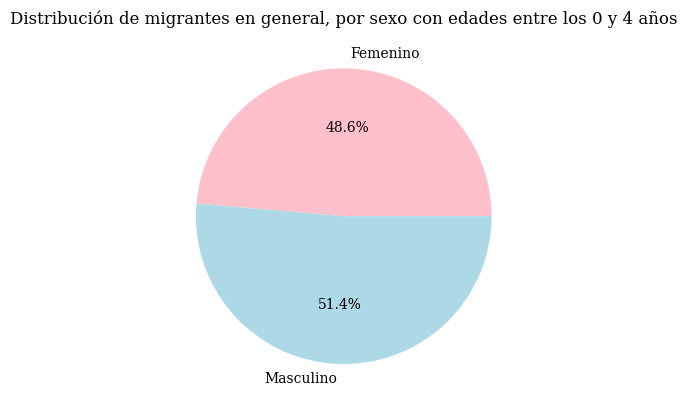

In [117]:
# Poner en español las etiquetas
df_1['sex'] = df_1['sex'].replace({'"Female"': 'Femenino', '"Male"': 'Masculino'})
colors = ['pink', 'lightblue']
plt.pie(df_1['cantidad_migrante'], labels=df_1['sex'], colors=colors, autopct='%1.1f%%')
plt.title('Distribución de migrantes en general, por sexo con edades entre los 0 y 4 años')
plt.show()

In [136]:
query_2 = """SELECT direction, sex, sum(estimate) as cantidad_llegadas from migracion_edad_g
where direction = '"Arrivals"' and sex not like '"TOTAL"'
group by sex,direction
"""
df_2 = pd.read_sql(query_2,engine)

print(df_2)

    direction       sex  cantidad_llegadas
0  "Arrivals"  "Female"          2552893.0
1  "Arrivals"    "Male"          2688370.0


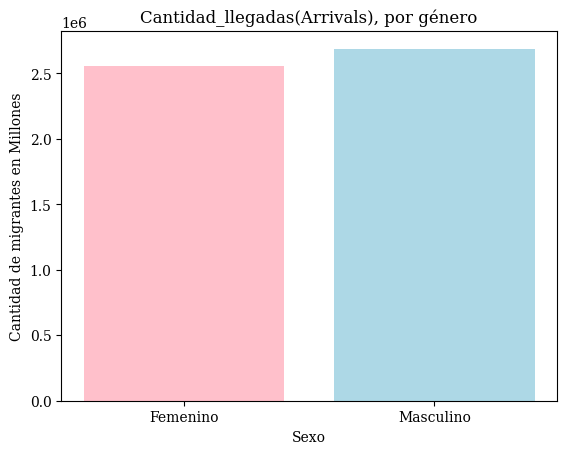

In [141]:
# Crea una figura y un eje para el gráfico de barras
fig, ax = plt.subplots()

df_2['sex'] = df_2['sex'].replace({'"Female"': 'Femenino', '"Male"': 'Masculino'})

# Define los datos para el gráfico de barras
datos = df_2['cantidad_llegadas']
etiquetas = df_2['sex']
colores = ['pink', 'lightblue']

# Crea el gráfico de barras
ax.bar(etiquetas, datos, color=colores)

# Agrega un título y etiquetas de ejes al gráfico
ax.set_title('Cantidad_llegadas(Arrivals), por género')
ax.set_xlabel('Sexo')
ax.set_ylabel('Cantidad de migrantes en Millones')

# Muestra el gráfico
plt.show()

In [142]:
query_3 = """SELECT direction, sex, sum(estimate) as cantidad_salidas from migracion_edad_g
where direction = '"Departures"' and sex not like '"TOTAL"'
group by sex,direction
"""
df_3 = pd.read_sql(query_3,engine)

print(df_3)

      direction       sex  cantidad_salidas
0  "Departures"  "Female"         1918985.0
1  "Departures"    "Male"         2057798.0


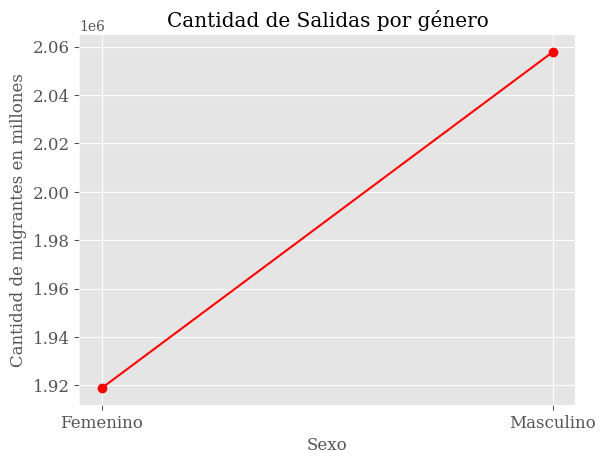

In [147]:
# Reemplaza los valores de sex por Femenino y Masculino
df_3['sex'] = df_3['sex'].replace({'"Female"': 'Femenino', '"Male"': 'Masculino'})

# Aplica el estilo ggplot al gráfico
style.use('ggplot')

# Crea una figura y un eje para el gráfico de líneas
fig, ax = plt.subplots()

# Define los datos para el gráfico de líneas
datos = df_3['cantidad_salidas']
etiquetas = df_3['sex']
color = 'red'

# Crea el gráfico de líneas
ax.plot(etiquetas, datos, color=color, marker='o')

# Agrega un título y etiquetas de ejes al gráfico
ax.set_title('Cantidad de Salidas por género')
ax.set_xlabel('Sexo')
ax.set_ylabel('Cantidad de migrantes en millones')

# Personaliza el estilo del gráfico
ax.tick_params(axis='both', which='major', labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)

# Muestra el gráfico
plt.show()

In [151]:
query_4 = """
SELECT age, sum(estimate) as total_migracion from migracion_edad_g
where age not like '"TOTAL"' and direction ='"Arrivals"'
group by age 
order by total_migracion desc 
limit 5
"""
df_4 = pd.read_sql(query_4,engine)

print(df_4)

             age  total_migracion
0  "25-29 years"         891448.0
1  "20-24 years"         712594.0
2  "30-34 years"         650073.0
3  "15-19 years"         453038.0
4  "35-39 years"         451766.0


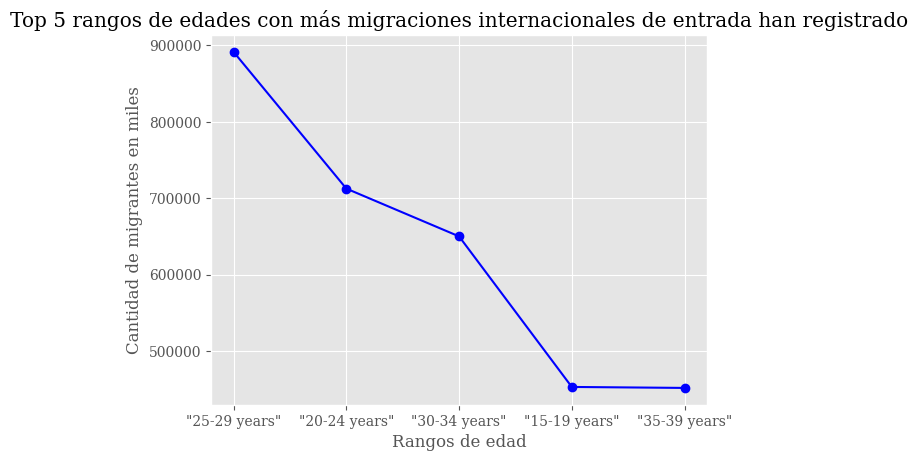

In [155]:
# Crea una figura y un eje para el gráfico de líneas
fig, ax = plt.subplots()

# Define los datos para el gráfico de líneas
datos = df_4['total_migracion']
etiquetas = df_4['age']
color = 'blue'

# Crea el gráfico de líneas
ax.plot(etiquetas, datos, color=color, marker='o')

# Agrega un título y etiquetas de ejes al gráfico
ax.set_title('Top 5 rangos de edades con más migraciones internacionales de entrada han registrado')
ax.set_xlabel('Rangos de edad')
ax.set_ylabel('Cantidad de migrantes en miles')

# Muestra el gráfico
plt.show()

In [154]:
query_5 = """
SELECT age, sum(estimate) as total_migracion from migracion_edad_g
where age not like '"TOTAL"' and direction ='"Departures"'
group by age 
order by total_migracion desc 
limit 5
"""
df_5 = pd.read_sql(query_5,engine)

print(df_5)

             age  total_migracion
0  "25-29 years"         705309.0
1  "20-24 years"         672134.0
2  "30-34 years"         430890.0
3  "35-39 years"         299708.0
4  "15-19 years"         281033.0


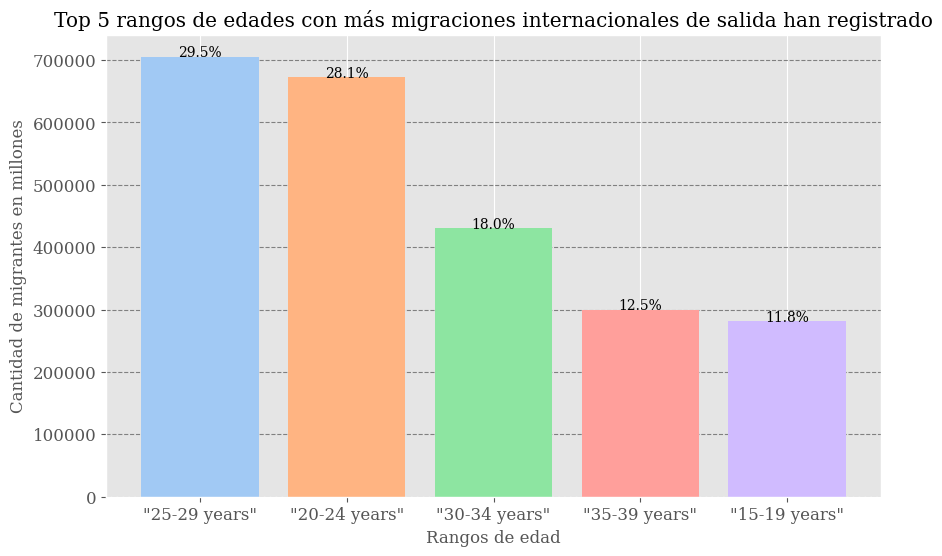

In [159]:
# Crea una figura y un eje para el gráfico de barras
fig, ax = plt.subplots()

# Define los datos para el gráfico de barras
datos = df_5['total_migracion']
etiquetas = df_5['age']
colores = sns.color_palette("pastel", len(etiquetas))

# Crea el gráfico de barras
ax.bar(etiquetas, datos, color=colores)

# Agrega etiquetas de porcentaje a las barras
total = sum(datos)
for i, v in enumerate(datos):
    porcentaje = '{:.1f}%'.format(v * 100 / total)
    ax.text(i, v + 0.1, porcentaje, ha='center', fontsize=10)

# Agrega un título y etiquetas de ejes al gráfico
ax.set_title('Top 5 rangos de edades con más migraciones internacionales de salida han registrado')
ax.set_xlabel('Rangos de edad')
ax.set_ylabel('Cantidad de migrantes en millones')

# Personaliza el estilo del gráfico
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.tick_params(axis='both', which='major', labelsize=12)

# Ajusta el tamaño de la figura
fig.set_size_inches(10, 6)

# Muestra el gráfico
plt.show()